<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#数据准备" data-toc-modified-id="数据准备-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>数据准备</a></span></li><li><span><a href="#LR" data-toc-modified-id="LR-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LR</a></span></li><li><span><a href="#FM" data-toc-modified-id="FM-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>FM</a></span></li><li><span><a href="#Xgboost-+-LR" data-toc-modified-id="Xgboost-+-LR-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Xgboost + LR</a></span></li><li><span><a href="#Xgboost-调参" data-toc-modified-id="Xgboost-调参-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Xgboost 调参</a></span><ul class="toc-item"><li><span><a href="#初始化参数" data-toc-modified-id="初始化参数-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>初始化参数</a></span></li><li><span><a href="#max_depth-和-min_weight-参数调优" data-toc-modified-id="max_depth-和-min_weight-参数调优-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>max_depth 和 min_weight 参数调优</a></span></li><li><span><a href="#gamma参数调优" data-toc-modified-id="gamma参数调优-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>gamma参数调优</a></span></li><li><span><a href="#调整subsample-和-colsample_bytree-参数" data-toc-modified-id="调整subsample-和-colsample_bytree-参数-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>调整subsample 和 colsample_bytree 参数</a></span></li><li><span><a href="#调整正则项系数" data-toc-modified-id="调整正则项系数-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>调整正则项系数</a></span></li><li><span><a href="#降低学习率" data-toc-modified-id="降低学习率-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>降低学习率</a></span></li><li><span><a href="#增加基模型的数量" data-toc-modified-id="增加基模型的数量-5.7"><span class="toc-item-num">5.7&nbsp;&nbsp;</span>增加基模型的数量</a></span></li></ul></li><li><span><a href="#LR调参" data-toc-modified-id="LR调参-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>LR调参</a></span></li><li><span><a href="#模型ROC曲线" data-toc-modified-id="模型ROC曲线-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>模型ROC曲线</a></span></li><li><span><a href="#Xgboost-+-FM" data-toc-modified-id="Xgboost-+-FM-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Xgboost + FM</a></span></li><li><span><a href="#汇总" data-toc-modified-id="汇总-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>汇总</a></span></li><li><span><a href="#不同模型的评估指标对比" data-toc-modified-id="不同模型的评估指标对比-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>不同模型的评估指标对比</a></span></li><li><span><a href="#对-Xgboost+FM进行调参处理，得到-log_loss-最小的那个模型" data-toc-modified-id="对-Xgboost+FM进行调参处理，得到-log_loss-最小的那个模型-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>对 Xgboost+FM进行调参处理，得到 log_loss 最小的那个模型</a></span></li></ul></div>

## 数据准备

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score


dataset = pd.read_csv("./train_sort_model_dataset.csv")
dataset.drop("Unnamed: 0", axis=1, inplace=True)
# dataset.drop("poemId", axis=1, inplace=True)

# 你会发现，热门数据起着主导作用，做了归一化之后各种指标都下去了
# poemStar做归一化
min_max_scaler = lambda x: (x-np.min(x)) / (np.max(x)-np.min(x))
dataset["poemStar"] = dataset[["poemStar"]].apply(min_max_scaler)
# dataset["rating"] = dataset[["rating"]].apply(min_max_scaler)
dataset.drop("rating",axis=1, inplace=True)

X, y = dataset.drop("label", axis=1), dataset.label
X = X.values
y = y.values

## LR

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=20)
lr_model = LogisticRegression()

# neg_log_loss 算的是负样本的 log_loss，其实就是在 log_loss 取负数
lr_acc = cross_val_score(lr_model, X, y, cv=cv).mean()
lr_auc = cross_val_score(lr_model, X, y, cv=cv, scoring="roc_auc").mean()
lr_log_loss = -cross_val_score(lr_model, X, y, cv=cv, scoring="neg_log_loss").mean()

print("Validation log loss: %.4f" % lr_log_loss)
print("Validation accuracy: %.4f" % lr_acc)
print("Validation auc:%.4f" % lr_auc)

lr_fpr_list = []
lr_tpr_list = []

# 控制变量
# 统一以最后一则交叉验证作为 histgram 的可视化
for index, fold in enumerate(cv.split(X)):
    
    train_data_index, test_data_index = fold
    X_train = X[train_data_index, :]
    y_train = y[train_data_index]
    X_test = X[test_data_index, :]
    y_test = y[test_data_index]

    LR = LogisticRegression()
    LR.fit(X_train, y_train)
    lr_y_pred_proba = LR.predict_proba(X_test)
#     if index == 4:
#         plt.figure(figsize=(10,5))
#         plt.xlabel("LogisticRegression predict probability histgram")
#         sns.distplot(lr_y_pred_proba, bins=20)
        
#         # 因为 AUC 都是 1，绘制 ROC 曲线其实没有太大的意义
#         plt.figure(figsize=(5,5))
#         fpr, tpr, threshold = roc_curve(y_test, LR.predict(X_test))
#         plt.plot(fpr, tpr, c='r')
#         plt.plot([0,1], [0,1], 'k--')
    fpr, tpr, threshold = roc_curve(y_test, LR.predict(X_test))
    lr_fpr_list.append(fpr);lr_tpr_list.append(tpr)

Validation log loss: 0.6404
Validation accuracy: 0.6717
Validation auc:0.6905


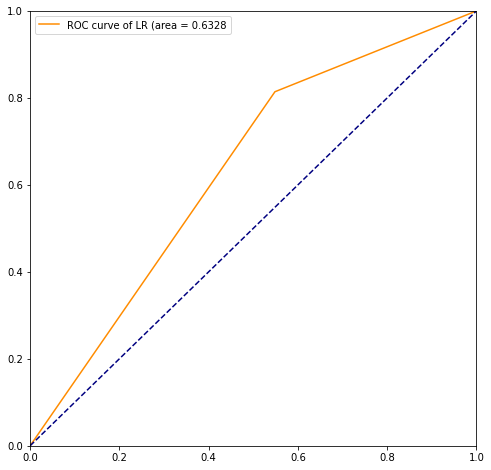

In [3]:
lr_fpr = sum(lr_fpr_list)/5
lr_tpr = sum(lr_tpr_list)/5
# lw = 2

plt.figure(figsize=(8,8))
plt.plot(lr_fpr, lr_tpr, color='darkorange',
         label='ROC curve of LR (area = {0:0.4f}'.format(auc(lr_fpr, lr_tpr)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.00])
plt.legend()

## FM

In [29]:
store_list = []

for i in X:
    d = dict()
    for index, j in enumerate(i):
        d[index] = j
    store_list.append(d)

num_factors : int, The dimensionality of the factorized 2-way interactions<br>
num_iter : int, 迭代次数<br>
learning_rate_schedule（可选参数） : string类型, 学习率迭代参数值:<br>
constant: η=η0<br>
optimal: η=1t+t0 [default]<br>
invscaling: η=η0/pow(t,power_t)<br>
initial_learning_rate : double, 初始时的学习率，默认等于 0.01<br>
task : 模型任务类型，string<br>
regression: Labels 为实数值.<br>
classification: Labels 为1或0.<br>
verbose : bool，是否需要打印当前迭代时的训练误差（training error）.<br>
power_t : double, The exponent for inverse scaling learning rate [默认值 0.5].<br>
t0 : double，learning_rate_schedule的初始值. 默认值 0.001.<br>

Validation log loss: 0.6436
Validation accuracy: 0.6650
Validation auc:0.6763


(0.0, 1.0)

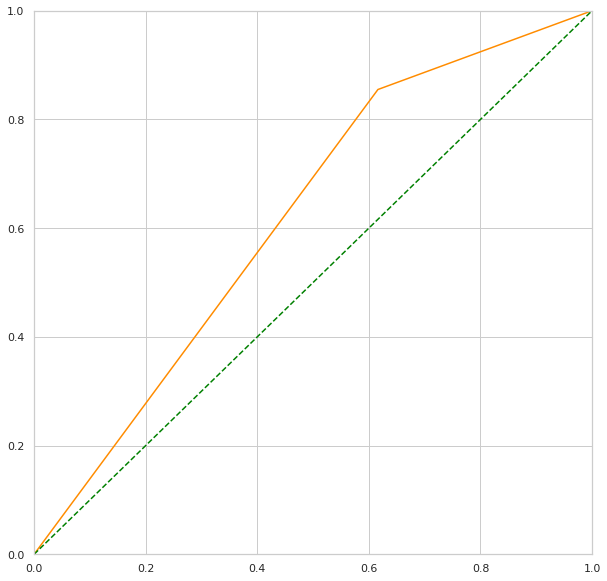

In [30]:
from sklearn.feature_extraction import DictVectorizer
from pyfm import pylibfm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss, accuracy_score

sns.set(style="whitegrid")
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=20)

log_loss_y = []
acc_y = []
auc_y = []
counter = 0

fm_fpr_list = []
fm_tpr_list = []

for fold in cv.split(store_list):
    train_data_index, test_data_index = fold
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for index in train_data_index:
        X_train.append(store_list[index])
        y_train.append(y[index])
        
    for index in test_data_index:
        X_test.append(store_list[index])
        y_test.append(y[index])
    
    v = DictVectorizer()
    X_train = v.fit_transform(X_train)
    X_test = v.transform(X_test)
    
    fm = pylibfm.FM(num_factors=10, 
                num_iter=20, 
                verbose=False, 
                task="classification", 
                initial_learning_rate=0.01, 
                learning_rate_schedule="optimal"
               )
    fm.fit(X_train, y_train)

    y_pred_proba = fm.predict(X_test)
    y_preds_label = y_pred_proba > 0.5
    
    fpr, tpr, threshold = roc_curve(y_test, y_preds_label)
    fm_fpr_list.append(fpr);fm_tpr_list.append(tpr)

#     if counter == 4:
#         plt.figure(figsize=(10,5))
#         plt.xlabel("Factorization Machine predict probability histgram")
#         sns.distplot(y_pred_proba, bins=20)
#     counter += 1
    
    _log_loss = log_loss(y_test, y_pred_proba)
    _acc = accuracy_score(y_test, y_preds_label)
    _auc = roc_auc_score(y_test, y_pred_proba)
    log_loss_y.append(_log_loss)
    acc_y.append(_acc)
    auc_y.append(_auc)


fm_log_loss = np.array(log_loss_y).mean()
fm_acc = np.array(acc_y).mean()
fm_auc = np.array(auc_y).mean()
print("Validation log loss: %.4f" % fm_log_loss)
print("Validation accuracy: %.4f" % fm_acc)
print("Validation auc:%.4f" % fm_auc)

fm_y_pred_proba = y_pred_proba


fm_fpr = sum(fm_fpr_list)/5
fm_tpr = sum(fm_tpr_list)/5
# lw = 2

plt.figure(figsize=(10,10))
plt.plot(fm_fpr, fm_tpr, color='darkorange',
         ) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

## Xgboost + LR

In [4]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.preprocessing import OneHotEncoder

model = xgb.XGBClassifier(nthread=4,     #含义：nthread=-1时，使用全部CPU进行并行运算（默认）, nthread=1时，使用1个CPU进行运算。
                          learning_rate=0.03,    #含义：学习率，控制每次迭代更新权重时的步长，默认0.3。调参：值越小，训练越慢。典型值为0.01-0.2。
                          n_estimators=100,       #含义：总共迭代的次数，即决策树的个数
                          max_depth=4,           #含义：树的深度，默认值为6，典型值3-10。调参：值越大，越容易过拟合；值越小，越容易欠拟合
                          gamma=0,               #含义：惩罚项系数，指定节点分裂所需的最小损失函数下降值。
                          subsample=0.5,       #含义：训练每棵树时，使用的数据占全部训练集的比例。默认值为1，典型值为0.5-1。调参：防止overfitting。
                          colsample_bytree=0.5,#训练每棵树时，使用的特征占全部特征的比例。默认值为1，典型值为0.5-1。调参：防止overfitting。
                         )

model.fit(X, y)
model.feature_importances_

array([0.02492031, 0.        , 0.        , ..., 0.00769823, 0.        ,
       0.01461484], dtype=float32)

## Xgboost 调参

In [26]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate as cross_validation
from sklearn import metrics

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['label'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['label'],eval_metric='auc')

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['label'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['label'], dtrain_predprob))

#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

target = 'label'

### 初始化参数

In [51]:
from sklearn.metrics import roc_auc_score, auc

predictors = [x for x in dataset.columns if x not in ['label']]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=140,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

X_train, X_test, y_train, y_test = train_test_split(dataset[predictors], dataset['label'])

xgb1.fit(X_train, y_train)
print("acc", xgb1.score(X_test, y_test))
print("auc", roc_auc_score(np.array(y_test.values), xgb1.predict(X_test)))

acc 0.71
auc 0.6810344827586207


### max_depth 和 min_weight 参数调优

In [17]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
                        min_child_weight=1, gamma=0, subsample=0.8,colsample_bytree=0.8,
                        objective= 'binary:logistic', nthread=4,scale_pos_weight=1, seed=27), 
                            param_grid = param_test1,scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(dataset[predictors],dataset[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

/home/liang/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([ 4.55528474,  7.23703232,  7.50631742,  7.95382962, 12.0475565 ,
          7.53493552, 18.7284523 , 12.80032225,  7.29959922,  6.2080029 ,
          9.96828833,  5.67603111]),
  'std_fit_time': array([1.69178267, 3.59022731, 2.15843025, 2.62781836, 6.57108353,
         7.31140135, 8.61629269, 8.359407  , 3.75723507, 3.65233561,
         6.76032006, 4.10040615]),
  'mean_score_time': array([0.04447098, 0.05305443, 0.047013  , 0.05251026, 0.04366417,
         0.06067195, 0.05352292, 0.05413494, 0.06919193, 0.0514739 ,
         0.04050679, 0.04986353]),
  'std_score_time': array([0.0125392 , 0.01021399, 0.00937822, 0.01365071, 0.01382998,
         0.00971657, 0.01888724, 0.02055267, 0.02431977, 0.0192723 ,
         0.02019748, 0.02412216]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?

最佳参数 max_depth:3 min_child_weight:1，因为之前使用的步长为2，现在缩小范围再调一次参数

In [18]:
param_test2 = {
 'max_depth':[1,2,3,4],
 'min_child_weight':[1,2,3]
}

gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
                        min_child_weight=1, gamma=0, subsample=0.8,colsample_bytree=0.8,
                        objective= 'binary:logistic', nthread=4,scale_pos_weight=1, seed=27), 
                            param_grid = param_test2,scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2.fit(dataset[predictors],dataset[target])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

/home/liang/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([4.07655315, 3.03411584, 3.98145094, 3.68075032, 6.47948823,
         5.40448008, 6.09021425, 7.18368287, 5.56211205, 8.67956815,
         9.10296631, 3.76407161]),
  'std_fit_time': array([4.13184991, 1.59503644, 2.52902439, 1.38787037, 1.4195728 ,
         3.70333182, 2.43969031, 3.2985513 , 1.85956209, 6.35042241,
         3.89976832, 3.82194732]),
  'mean_score_time': array([0.05774355, 0.05312963, 0.03073654, 0.04100685, 0.05969992,
         0.05526714, 0.0566864 , 0.05018888, 0.06741891, 0.05205755,
         0.04121785, 0.04302425]),
  'std_score_time': array([0.01608402, 0.02226684, 0.00403161, 0.00983964, 0.00587837,
         0.01684849, 0.02034015, 0.0110057 , 0.00991016, 0.02310155,
         0.00904933, 0.02595907]),
  'param_max_depth': masked_array(data=[1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
         

此时最优参数是 max_depth:4  min_child_weight:1

### gamma参数调优

In [22]:
param_test3 = {
 'gamma':[i/10.0 for i in range(9)]
}


gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=4,
                        min_child_weight=1, gamma=0, subsample=0.8,colsample_bytree=0.8,
                        objective= 'binary:logistic', nthread=4,scale_pos_weight=1, seed=27), 
                            param_grid = param_test3,scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch3.fit(dataset[predictors],dataset[target])
gsearch3.best_params_, gsearch3.best_score_

/home/liang/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'gamma': 0.3}, 0.7151442835198596)

最优参数为 gamma: 0.3

### 调整subsample 和 colsample_bytree 参数

In [54]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=4, 
                                                  min_child_weight=1, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27),
                        param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch4.fit(dataset[predictors],dataset[target])
gsearch4.best_params_, gsearch4.best_score_

/home/liang/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'colsample_bytree': 0.6, 'subsample': 0.9}, 0.7159309852973448)

减小步长再调一次

In [55]:
param_test5 = {
 'subsample':[i/100.0 for i in range(40, 75, 5)],
 'colsample_bytree':[i/100.0 for i in range(70 , 100, 5)]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=4, 
                                                  min_child_weight=1, gamma=0.3, subsample=0.9, colsample_bytree=0.6,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27),
                        param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch5.fit(dataset[predictors],dataset[target])
gsearch5.best_params_, gsearch5.best_score_

/home/liang/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'colsample_bytree': 0.75, 'subsample': 0.65}, 0.7129125521176213)

### 调整正则项系数

In [56]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=4, 
                                                  min_child_weight=1, gamma=0.3, subsample=0.9, colsample_bytree=0.6,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27),
                        param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch6.fit(dataset[predictors],dataset[target])
gsearch6.best_params_, gsearch6.best_score_

/home/liang/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'reg_alpha': 0.01}, 0.716088983980689)

In [57]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=4, 
                                                  min_child_weight=1, gamma=0.3, subsample=0.9, colsample_bytree=0.6,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27),
                        param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch7.fit(dataset[predictors],dataset[target])
gsearch7.best_params_, gsearch6.best_score_

/home/liang/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'reg_alpha': 0.05}, 0.716088983980689)

### 降低学习率

In [60]:
param_test8 = {
 'learning_rate':[0.01, 0.05, 0.1]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=4,reg_alpha=0.05, 
                                                  min_child_weight=1, gamma=0.3, subsample=0.9, colsample_bytree=0.6,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27),
                        param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch8.fit(dataset[predictors],dataset[target])
gsearch8.best_params_, gsearch8.best_score_

/home/liang/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'learning_rate': 0.01}, 0.7187074829931972)

### 增加基模型的数量

In [61]:
param_test9 = {
 'n_estimators':[50, 100, 150, 200, 250, 300, 350, 400]
}
gsearch9 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.01, n_estimators=140, max_depth=4,reg_alpha=0.05, 
                                                  min_child_weight=1, gamma=0.3, subsample=0.9, colsample_bytree=0.6,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27),
                        param_grid = param_test9, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch9.fit(dataset[predictors],dataset[target])
gsearch9.best_params_, gsearch9.best_score_

/home/liang/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'n_estimators': 300}, 0.7200861312266842)

In [73]:
xgb2 = XGBClassifier(
 learning_rate =0.05,
 n_estimators=300,
 max_depth=4,
 min_child_weight=1,
 gamma=0.3,
 subsample=0.9,
 reg_alpha=0.05,
 colsample_bytree=0.6,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

xgb2.fit(dataset[predictors].values, dataset['label'].values)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=27, reg_alpha=0.05,
              reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.9,
              tree_method=None, validate_parameters=False, verbosity=None)

In [74]:
cols = dataset.drop("label", axis=1).columns
feature_score = list(zip(cols, xgb2.feature_importances_))
feature_score = sorted(feature_score, key=lambda tup:tup[1], reverse=True)[:10]
feature_score

[('诗经', 0.039772246),
 ('赞美', 0.038918853),
 ('先秦', 0.03542062),
 ('古诗三百首', 0.033082176),
 ('初中文言文', 0.030312577),
 ('抱负', 0.029126126),
 ('唐代', 0.026585966),
 ('爱情', 0.026146589),
 ('抒怀', 0.02516353),
 ('咏物', 0.023291534)]

In [78]:
train_new_feature = xgb2.apply(dataset[predictors].values)
train_new_feature = train_new_feature.reshape(-1, 300)
enc = OneHotEncoder()
enc.fit(train_new_feature)
train_new_feature2 = np.array(enc.transform(train_new_feature).toarray())

In [79]:
# 经过 xgboost 特征编码之后的特征集
train_new_feature2

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

没调参前LR模型的评估指标
Validation log loss: 0.6032
Validation accuracy: 0.7617
Validation auc:0.8078

In [31]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=20)
lr_model = LogisticRegression()

# neg_log_loss 算的是负样本的 log_loss，其实就是在 log_loss 取负数
xgb_lr_acc = cross_val_score(lr_model, train_new_feature2, y, cv=cv).mean()
xgb_lr_auc = cross_val_score(lr_model, train_new_feature2, y, cv=cv, scoring="roc_auc").mean()
xgb_lr_log_loss = -cross_val_score(lr_model, train_new_feature2, y, cv=cv, scoring="neg_log_loss").mean()


xgb_lr_fpr_list = list()
xgb_lr_tpr_list = list()

print("Validation log loss: %.4f" % xgb_lr_log_loss)
print("Validation accuracy: %.4f" % xgb_lr_acc)
print("Validation auc:%.4f" % xgb_lr_auc)

# 控制变量
# 统一以最后一则交叉验证作为 histgram 的可视化
for index, fold in enumerate(cv.split(X)):
#     if index == 4:
    train_data_index, test_data_index = fold
    X_train = train_new_feature2[train_data_index, :]
    y_train = y[train_data_index]
    X_test = train_new_feature2[test_data_index, :]
    y_test = y[test_data_index]

    LR = LogisticRegression()
    LR.fit(X_train, y_train)
    xgb_lr_y_pred_proba = LR.predict_proba(X_test)
#         plt.figure(figsize=(10,5))
#         plt.xlabel("Xgboost+LogisticRegression predict probability histgram")
#         sns.distplot(lr_y_pred_proba, bins=20)
    fpr, tpr, threshold = roc_curve(y_test, LR.predict(X_test))
    xgb_lr_fpr_list.append(fpr);xgb_lr_tpr_list.append(tpr)

/home/liang/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/liang/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

Validation log loss: 0.6032
Validation accuracy: 0.7617
Validation auc:0.8078


/home/liang/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/liang/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

In [84]:
import warnings
warnings.filterwarnings('ignore')

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=20)
lr_model = LogisticRegression()

# neg_log_loss 算的是负样本的 log_loss，其实就是在 log_loss 取负数
xgb_lr_acc = cross_val_score(lr_model, train_new_feature2, y, cv=cv).mean()
xgb_lr_auc = cross_val_score(lr_model, train_new_feature2, y, cv=cv, scoring="roc_auc").mean()
xgb_lr_log_loss = -cross_val_score(lr_model, train_new_feature2, y, cv=cv, scoring="neg_log_loss").mean()


xgb_lr_fpr_list = list()
xgb_lr_tpr_list = list()

print("Validation log loss: %.4f" % xgb_lr_log_loss)
print("Validation accuracy: %.4f" % xgb_lr_acc)
print("Validation auc:%.4f" % xgb_lr_auc)

# 控制变量
# 统一以最后一则交叉验证作为 histgram 的可视化
for index, fold in enumerate(cv.split(X)):
#     if index == 4:
    train_data_index, test_data_index = fold
    X_train = train_new_feature2[train_data_index, :]
    y_train = y[train_data_index]
    X_test = train_new_feature2[test_data_index, :]
    y_test = y[test_data_index]

    LR = LogisticRegression()
    LR.fit(X_train, y_train)
    xgb_lr_y_pred_proba = LR.predict_proba(X_test)
#         plt.figure(figsize=(10,5))
#         plt.xlabel("Xgboost+LogisticRegression predict probability histgram")
#         sns.distplot(lr_y_pred_proba, bins=20)
    fpr, tpr, threshold = roc_curve(y_test, LR.predict(X_test))
    xgb_lr_fpr_list.append(fpr);xgb_lr_tpr_list.append(tpr)

Validation log loss: 0.5371
Validation accuracy: 0.8100
Validation auc:0.8669


## LR调参

In [86]:
param_test = {
    'C':[0.1, 0.5, 0.7, 1, 2,5, 10],
    'max_iter':[50, 100, 150, 200, 250]
}
gsearch = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch.fit(train_new_feature2, y)
gsearch.best_params_, gsearch.best_score_

({'C': 0.1, 'max_iter': 100}, 0.8582636603028309)

In [87]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=20)
lr_model = LogisticRegression(C=0.1, max_iter=100)

# neg_log_loss 算的是负样本的 log_loss，其实就是在 log_loss 取负数
xgb_lr_acc = cross_val_score(lr_model, train_new_feature2, y, cv=cv).mean()
xgb_lr_auc = cross_val_score(lr_model, train_new_feature2, y, cv=cv, scoring="roc_auc").mean()
xgb_lr_log_loss = -cross_val_score(lr_model, train_new_feature2, y, cv=cv, scoring="neg_log_loss").mean()


xgb_lr_fpr_list = list()
xgb_lr_tpr_list = list()

print("Validation log loss: %.4f" % xgb_lr_log_loss)
print("Validation accuracy: %.4f" % xgb_lr_acc)
print("Validation auc:%.4f" % xgb_lr_auc)

# 控制变量
# 统一以最后一则交叉验证作为 histgram 的可视化
for index, fold in enumerate(cv.split(X)):
#     if index == 4:
    train_data_index, test_data_index = fold
    X_train = train_new_feature2[train_data_index, :]
    y_train = y[train_data_index]
    X_test = train_new_feature2[test_data_index, :]
    y_test = y[test_data_index]

    LR = LogisticRegression()
    LR.fit(X_train, y_train)
    xgb_lr_y_pred_proba = LR.predict_proba(X_test)
#         plt.figure(figsize=(10,5))
#         plt.xlabel("Xgboost+LogisticRegression predict probability histgram")
#         sns.distplot(lr_y_pred_proba, bins=20)
    fpr, tpr, threshold = roc_curve(y_test, LR.predict(X_test))
    xgb_lr_fpr_list.append(fpr);xgb_lr_tpr_list.append(tpr)

Validation log loss: 0.4440
Validation accuracy: 0.7983
Validation auc:0.8697


## 模型ROC曲线

(0.0, 1.0)

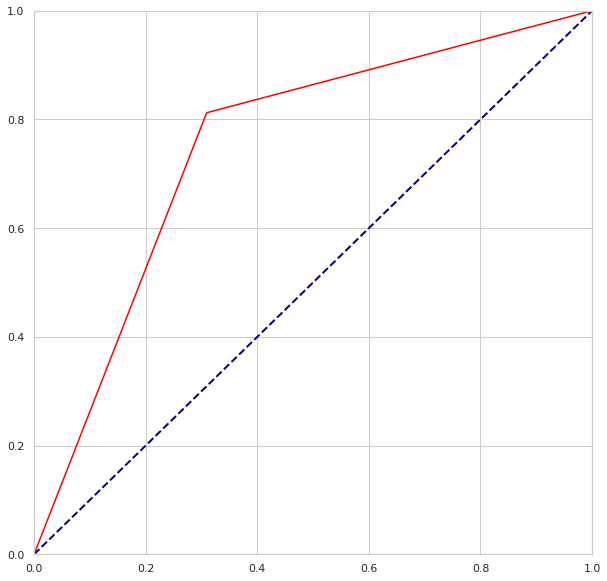

In [32]:
xgb_lr_fpr = sum(xgb_lr_fpr_list)/5
xgb_lr_tpr = sum(xgb_lr_tpr_list)/5
# lw = 2

plt.figure(figsize=(10,10))
plt.plot(xgb_lr_fpr, xgb_lr_tpr, color='red',
         ) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.00])

(0.0, 1.0)

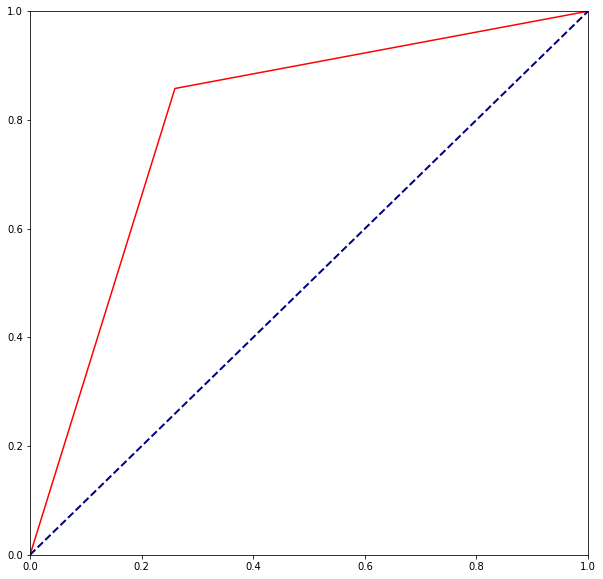

In [82]:
xgb_lr_fpr = sum(xgb_lr_fpr_list)/5
xgb_lr_tpr = sum(xgb_lr_tpr_list)/5
# lw = 2

plt.figure(figsize=(10,10))
plt.plot(xgb_lr_fpr, xgb_lr_tpr, color='red',
         ) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.00])

## Xgboost + FM

In [33]:
store_list2 = []

for i in train_new_feature2:
    d = dict()
    for index, j in enumerate(i):
        d[index] = j
    store_list2.append(d)

Validation log loss: 0.7244
Validation accuracy: 0.7217
Validation auc:0.7961


(0.0, 1.0)

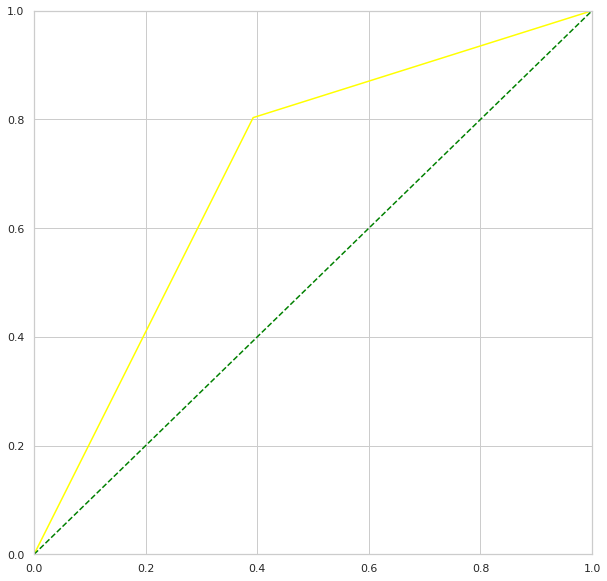

In [34]:
xgb_fm_log_loss_y = []
xgb_fm_acc_y = []
xgb_fm_auc_y = []
counter = 0

xgb_fm_fpr_list = []
xgb_fm_tpr_list = []

for fold in cv.split(store_list2):
    train_data_index, test_data_index = fold
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for index in train_data_index:
        X_train.append(store_list2[index])
        y_train.append(y[index])
        
    for index in test_data_index:
        X_test.append(store_list2[index])
        y_test.append(y[index])
    
    v = DictVectorizer()
    X_train = v.fit_transform(X_train)
    X_test = v.transform(X_test)
    
    fm = pylibfm.FM(num_factors=10, 
                num_iter=20, 
                verbose=False, 
                task="classification", 
                initial_learning_rate=0.01, 
                learning_rate_schedule="optimal"
               )
    fm.fit(X_train, y_train)

    y_pred_proba = fm.predict(X_test)
    y_preds_label = y_pred_proba > 0.5
    fpr, tpr, threshold = roc_curve(y_test, y_preds_label)
    xgb_fm_fpr_list.append(fpr);xgb_fm_tpr_list.append(tpr)
#     if counter == 4:
#         plt.figure(figsize=(10,5))
#         plt.xlabel("Xgboost+Factorization Machine predict probability histgram")
#         sns.distplot(y_pred_proba, bins=20)
#     counter += 1
    
    _log_loss = log_loss(y_test, y_pred_proba)
    _acc = accuracy_score(y_test, y_preds_label)
    _auc = roc_auc_score(y_test, y_pred_proba)
    xgb_fm_log_loss_y.append(_log_loss)
    xgb_fm_acc_y.append(_acc)
    xgb_fm_auc_y.append(_auc)


xgb_fm_log_loss = np.array(xgb_fm_log_loss_y).mean()
xgb_fm_acc = np.array(xgb_fm_acc_y).mean()
xgb_fm_auc = np.array(xgb_fm_auc_y).mean()
print("Validation log loss: %.4f" % xgb_fm_log_loss)
print("Validation accuracy: %.4f" % xgb_fm_acc)
print("Validation auc:%.4f" % xgb_fm_auc)

xgb_fm_y_pred_proba = y_pred_proba


xgb_fm_fpr = sum(xgb_fm_fpr_list)/5
xgb_fm_tpr = sum(xgb_fm_tpr_list)/5
# lw = 2

plt.figure(figsize=(10,10))
plt.plot(xgb_fm_fpr, xgb_fm_tpr, color='yellow',
         ) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

## 汇总

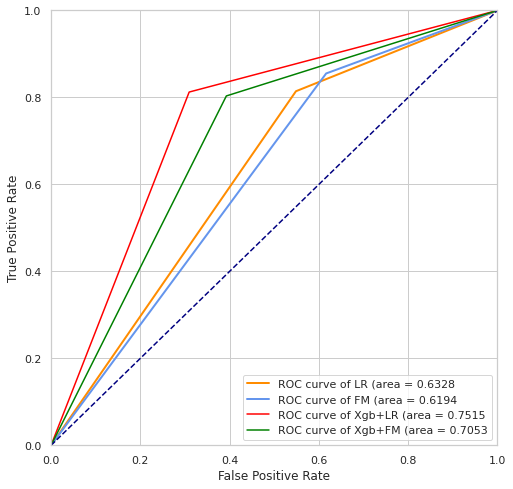

In [58]:
# roc曲线对比
plt.figure(figsize=(8,8))
plt.plot(lr_fpr, lr_tpr, color='darkorange',lw=2,
         label='ROC curve of LR (area = {0:0.4f}'.format(auc(lr_fpr, lr_tpr)))

plt.plot(fm_fpr, fm_tpr, color='cornflowerblue',lw=2,
         label='ROC curve of FM (area = {0:0.4f}'.format(auc(fm_fpr, fm_tpr))) 

plt.plot(xgb_lr_fpr, xgb_lr_tpr, color='red',
         label='ROC curve of Xgb+LR (area = {0:0.4f}'.format(auc(xgb_lr_fpr, xgb_lr_tpr)))

plt.plot(xgb_fm_fpr, xgb_fm_tpr, color='green',
         label='ROC curve of Xgb+FM (area = {0:0.4f}'.format(auc(xgb_fm_fpr, xgb_fm_tpr)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.00])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

## 不同模型的评估指标对比

In [12]:
x = xgb_fm_log_loss, xgb_lr_log_loss, lr_log_loss, fm_log_loss
x

(0.0004393827170300171,
 0.0015939398242846008,
 0.6607333964740537,
 0.6664767562822027)

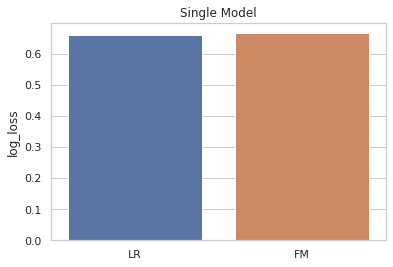

In [13]:
plt.title("Single Model")
plt.ylabel("log_loss")
sns.barplot(x=["LR", "FM"], y=x[2:])

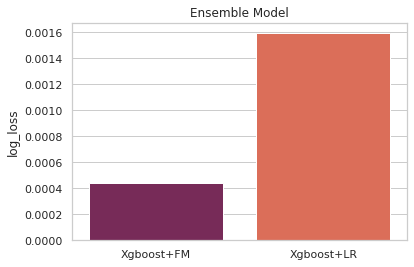

In [14]:
plt.title("Ensemble Model")
plt.ylabel("log_loss")
sns.barplot(x=["Xgboost+FM", "Xgboost+LR"], y=x[:2], palette="rocket")

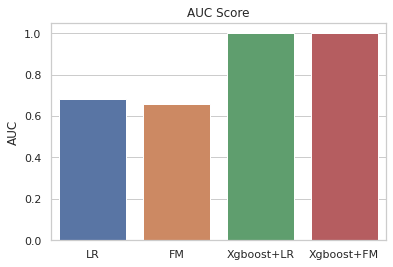

In [15]:
# plt.figure(figsize=(10, 10))
plt.title("AUC Score")
plt.ylabel("AUC")
sns.barplot(x=["LR", "FM", "Xgboost+LR", "Xgboost+FM"], y=[lr_auc, fm_auc, xgb_lr_auc, xgb_fm_auc])

## 对 Xgboost+FM进行调参处理，得到 log_loss 最小的那个模型